## This notebook contains prototyping work for implementing the viterbi decode algorithm

[  1.9969161    7.84834467   8.33596372   8.40562358   8.54494331
  10.93659864  12.07437642  21.59455782  22.33759637  23.05741497
  23.77723356  24.56671202  25.2400907   25.9599093   26.67972789
  27.58530612  28.11936508  28.30512472  29.02494331  29.7447619
  29.83764172  30.30204082  30.48780045  30.58068027  31.02185941
  31.9506576   32.48471655  34.13333333  34.69061224  34.87637188
  40.93678005  41.49405896  43.88571429  44.16435374  45.95229025
  46.78820862  47.09006803  48.25106576  48.87800454  49.34240363
  49.66748299  49.99256236  50.13188209  50.27120181  50.96780045
  51.710839    51.94303855  52.1752381   52.45387755  52.89505669
  53.17369615  53.7077551   54.07927438  54.52045351  57.39972789
  58.70004535  65.75891156  67.24498866  68.49886621  74.14131519
  75.62739229  77.11346939  77.64752834  78.22802721  81.36272109
  81.94321995  82.91845805  83.26675737  83.61505669  91.67238095
  94.48199546  95.1321542   95.36435374  95.66621315  95.85197279
  99.683265

<ipython-input-8-77970c2ce38c>:40: RuntimeWarning: divide by zero encountered in log
  A = np.log(A)


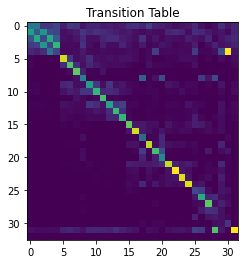

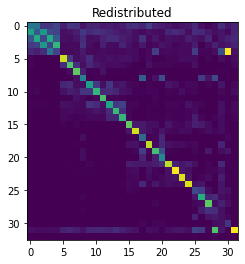

In [8]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

def redistribute_trans_table(A):
    for i in range(5,A.shape[1]):
        current_col = A[:,i]
        idx = (-current_col).argsort()[:2]
        second_max_val = current_col[idx[1]]
        current_col[idx[0]] = second_max_val
        new_array = (current_col/current_col.sum(axis=0))
        A[:,i] = new_array
    
    for i in range(0,5):
        current_col = A[:,i]
        idx = (-current_col).argsort()[:1]
        max_val = current_col[idx[0]]
        new_array = np.zeros_like(A[5:,i])
        new_array = np.random.uniform(low=0,high=max_val,size=new_array.shape[0])
        A[5:,i] = new_array
        A[:,i] = A[:,i]/(A[:,i].sum(axis=0))
    
    return A

def viterbi(A, B, sequence, B_weight=1):
    '''

    ~~~~ ARGUMENTS ~~~~
    sequence : list
        - a sequence of labels
    A : numpy array
        - transition table
        - shape = [number of notes + 1 for <start>, number of notes]
        - NOTE: the <start> token should be indexed at the last row
    B : numpy array
        - emission table
        - shape = [number of notes, number of possible labels]
    '''
    # let's work in log space
    A = np.log(A)
    B = np.log(B*B_weight)

    num_notes = B.shape[0]

    # create empty viterbi matrix and backpointer matrix
    viterbi = np.full((num_notes, len(sequence)), None)
    bp = np.full((num_notes, len(sequence)), None)

    # Compute the first column
    first_label = sequence[0]
    start_token = A.shape[0]
    for n in range(num_notes):
        viterbi[n,0] = A[-1,n] + B[n,first_label]
        bp[n,0] = start_token

    for w in range(1, len(sequence)):
        for n in range(num_notes):
            viterbi[n,w], bp[n,w] = compute_viterbi_val(n=n, w=w, viterbi=viterbi, A_prev=A[:,n], B_prev=B[n,w]) #transitions from previous note to current note

    # Find maximum value of last column of viterbi
    max_idx = np.argmax(viterbi[:,-1])
    # Trace back maximum indices in backpointer table
    note_sequence = [max_idx]
    next_note = bp[max_idx,-1]
    for i in range(1,len(sequence)):
        reverse_i = len(sequence)-i
        # print('reverse_i : {}'.format(reverse_i))
        note_sequence.append(bp[next_note, reverse_i])
        next_note = bp[next_note, reverse_i]
        # print('next_note: {}'.format(next_note))


    # for i in range(0,len(sequence)):
        # reverse_i = len(sequence)-i-1
        # print(f'[{i-1},{reverse_i}]')
        # note_sequence.append(bp[note_sequence[i-1], reverse_i])
    
    note_sequence.reverse()
    return note_sequence, viterbi, bp

def compute_viterbi_val(n, w, viterbi, A_prev, B_prev):
    # Compute first viterbi value
    current_val = viterbi[0,w-1] + A_prev[0] + B_prev
    max_val = current_val
    bp = 0

    # Loop through rest of values
    for i, v in enumerate(list(viterbi[:,w-1])):
        current_val = v + A_prev[i] + B_prev
        if current_val > max_val:
            max_val = current_val
            bp = i
    
    return max_val, bp

def make_emission_table():
    # Numpy array
    em_table = np.random.uniform(0,1,(32,12000))
    new_array = (em_table/em_table.sum(axis=0))
    return new_array

def onset_label(onset, spectrogram=None):
    '''
    Function that takes in 1D onset array and spectrogram and labels each onset with the spectrogram that most closely
    matches the emission probability table

    INPUTS: 1D Onset Array , computed spectrogram
    OUTPUTS: 1D Array of same length as onset array corresponding to column indices of emission probability table 
    '''
    # X will probably need to be determined by spectrogram clusters , set locally just to highlight
    X = 12000
    return np.random.randint(0,X,len(onset))

def onset_time(processed_path):

    # Load the songs and the notes arrays one at a time
    # for idx in range (len(song_paths)):
    # Load the song
    y, sr = librosa.load(processed_path)

    # resample the song if it isn't sr=22050 (for consistent sizing)
    if not sr == 22050:
        y = librosa.resample(y, sr, 22050)
        sr = 22050

    #source seperation, margin can be tuned 
    y_harmonic, y_percussive = librosa.effects.hpss(y, margin=2.0)

    # Set Hop_len
    hop_len = 520

    onset_frame_backtrack = librosa.onset.onset_detect(y_harmonic, sr = sr, hop_length = hop_len, backtrack=True)
    onset_times = librosa.frames_to_time(onset_frame_backtrack)

    return y_harmonic, onset_times

# Load and modify transition table
A = np.load('trans_prob_table.npy')
# A_redistributed = redistribute_trans_table(A)

# Display
plt.figure()
plt.imshow(A)
plt.title('Transition Table')
plt.figure()
plt.imshow(A)
plt.title('Redistributed')

song_path = r'X:\Training Data\Unprocessed\Angevil Hero II\1. John 5 - 27 Needles\song.ogg'
_, onset_times = onset_time(song_path)

print(onset_times)

onset = [0 for _ in range(1000)]

B = make_emission_table()
sequence = onset_label(onset)

note_sequence, v, bp = viterbi(A_redistributed, B, sequence)
# print(note_sequence)

In [9]:
def onset_time_bins(onset_times):
    otb = [int(x) for x in onset_times*100]
    return otb

otb = onset_time_bins(onset_times)
print(otb)

[199, 784, 833, 840, 854, 1093, 1207, 2159, 2233, 2305, 2377, 2456, 2524, 2595, 2667, 2758, 2811, 2830, 2902, 2974, 2983, 3030, 3048, 3058, 3102, 3195, 3248, 3413, 3469, 3487, 4093, 4149, 4388, 4416, 4595, 4678, 4709, 4825, 4887, 4934, 4966, 4999, 5013, 5027, 5096, 5171, 5194, 5217, 5245, 5289, 5317, 5370, 5407, 5452, 5739, 5870, 6575, 6724, 6849, 7414, 7562, 7711, 7764, 7822, 8136, 8194, 8291, 8326, 8361, 9167, 9448, 9513, 9536, 9566, 9585, 9968, 10188, 10265, 10625, 10799, 11173, 11205, 11442, 11570, 11709, 11735, 11807, 12002, 12027, 12181, 12227, 12292, 12390, 12462, 12487, 12538, 12585, 12613, 12701, 12745, 13033, 13212, 13344, 13395, 13544, 14022, 14199, 14928, 15132, 15169, 15181, 15225, 15891, 17085, 17152, 17224, 17298, 17370, 17426, 17735, 17758, 17809, 18485, 19451, 19797, 19850, 20384, 22186, 23352, 23500, 23577, 23886, 23949, 23956, 24643, 24661, 24682, 24701, 24719, 24733, 24791, 24808, 24884, 24938, 24970, 24991, 25010, 25026, 25098, 25189, 25281, 25319, 25393, 25430, 25

In [10]:
note_sequence

[0,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 20,
 20,
 19,
 19,
 19,
 19,
 19,
 19,
 0,
 6,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 9,
 12,
 10,
 9,
 9,
 12,
 14,
 14,
 14,
 14,
 14,
 12,
 12,
 14,
 14,
 14,
 12,
 12,
 9,
 9,
 10,
 9,
 10,
 8,
 28,
 2,
 31,
 10,
 10,
 10,
 10,
 10,
 10,
 9,
 6,
 5,
 5,
 6,
 5,
 6,
 5,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 5,
 5,
 9,
 10,
 9,
 12,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 12,
 13,
 12,
 13,
 13,
 13,
 13,
 0,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 20,
 20,
 17,
 17,
 20,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 20,
 0,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 0,
 18,
 18,
 18,
 18,
 18,
 18,
 20,
 20,
 20,
 20,
 19,
 19,
 19,
 19,
 19,
 0,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 1,
 10,
 10,
 9,
 12,
 12,
 12,
 0,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 0,
 6,
 6,
 5,
 5,
 6,
 9,
 9,
 12,
 13,
 12,
 14,
 14,
 12,
 9,
 1

In [15]:
import matplotlib.pyplot as plt

def make_emission_table():
    # Numpy array
    em_table = np.random.uniform(0,1,(32,12000))
    new_array = (em_table/em_table.sum(axis=0))
    return new_array

def onset_label(onset, spectrogram=None):
    '''
    Function that takes in 1D onset array and spectrogram and labels each onset with the spectrogram that most closely
    matches the emission probability table

    INPUTS: 1D Onset Array , computed spectrogram
    OUTPUTS: 1D Array of same length as onset array corresponding to column indices of emission probability table 
    '''
    # X will probably need to be determined by spectrogram clusters , set locally just to highlight
    X = 12000
    return np.random.randint(0,X,len(onset))

onset = [0 for _ in range(1000)]
A = np.load('trans_prob_table.npy')
B = make_emission_table()
sequence = onset_label(onset)

note_sequence = viterbi(A, B, sequence)
print(note_sequence)




<ipython-input-1-a8acb854a426>:18: RuntimeWarning: divide by zero encountered in log
  A = np.log(A)


[33, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,

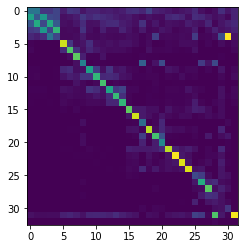

In [28]:
plt.imshow(A)

0.07141228448868536


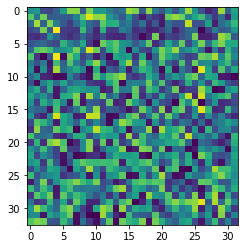

In [62]:
def redistribute_trans_table(A):
    for i in range(5,A.shape[1]):
        current_col = A[:,i]
        idx = (-current_col).argsort()[:2]
        second_max_val = current_col[idx[1]]
        current_col[idx[0]] = second_max_val
        new_array = (current_col/current_col.sum(axis=0))
        A[:,i] = new_array
    
    for i in range(0,5):
        current_col = A[:,i]
        idx = (-current_col).argsort()[:1]
        max_val = current_col[idx[0]]
        new_array = np.zeros_like(A[5:,i])
        new_array = np.random.uniform(low=0,high=max_val,size=new_array.shape[0])
        A[5:,i] = new_array
        A[:,i] = A[:,i]/(A[:,i].sum(axis=0))
    
    return A

# A_fully_redistributed = redistribute_trans_table(A)
A_redistributed = redistribute_trans_table(A)
plt.imshow(A_redistributed)
print(np.max(A_redistributed))